In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, json, copy, pickle
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, get_sun
from astropy.coordinates import Angle
from astropy.cosmology import Planck18 as cosmo
from astropy import constants
from astropy import units as u
from alerts import get_alerts
from style import output_folder, big_fontsize, base_width, base_height, dpi, CB_color_cycle, bandcols
import seaborn as sns
from astropy.time import Time

from tqdm import tqdm

from scipy.optimize import root
from scipy.interpolate import interp1d
from scipy.integrate import quad, fixed_quad, quadrature, romberg

from flarestack.cosmo import get_rate, define_cosmology_functions
plt.style.use('tableau-colorblind10')

No scratch directory has been set. Using home directory as default.


In [3]:
completenesses = dict()

for band in ["g", "V"]:
    gdat = pd.read_csv(f"data/comp_vs_m{band}.csv", skiprows=7)
    # gdat = gdat[gdat[f"m_{band}"] > 12]

    magcols = [c for c in gdat.columns if "m" not in c]
    normed = gdat[magcols] / gdat[magcols].iloc[0]
    qs_vals = [0.5, 0.05, 0.95]
    qs = normed.quantile(qs_vals, axis="columns")

    ms = gdat[f"m_{band}"].loc[normed.index]
    
    interps = dict()
    for th in qs_vals:
        interps[th] = interp1d(ms, qs.loc[th])

    completenesses[band] = interps
    
with open("data/completenes_functions.pkl", "wb") as f:
    pickle.dump(completenesses, f)

In [45]:
completenesses

{'g': {0.5: <scipy.interpolate.interpolate.interp1d at 0x7fd76b32d400>,
  0.05: <scipy.interpolate.interpolate.interp1d at 0x7fd76b32d4a0>,
  0.95: <scipy.interpolate.interpolate.interp1d at 0x7fd76b32d540>},
 'V': {0.5: <scipy.interpolate.interpolate.interp1d at 0x7fd76c51a8b0>,
  0.05: <scipy.interpolate.interpolate.interp1d at 0x7fd76b32d360>,
  0.95: <scipy.interpolate.interpolate.interp1d at 0x7fd76b32d590>}}

In [1]:
completeness_mag = {'g': 17.5, 'V': 16.5}

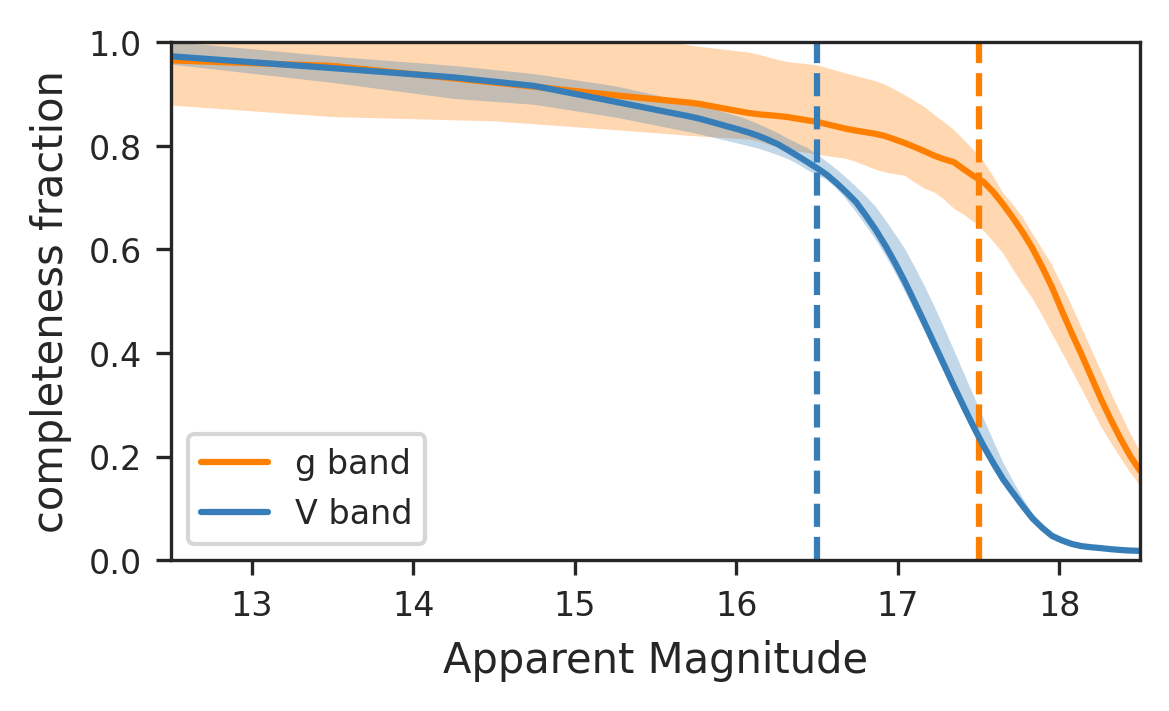

In [13]:
fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
plot_ms = np.linspace(12.5, 18.5, 100)
for band, interps in completenesses.items():
    ax.plot(plot_ms, interps[0.5](plot_ms), color=bandcols[band], label=f"{band} band")
    ax.fill_between(plot_ms, interps[0.05](plot_ms), interps[0.95](plot_ms), 
                    alpha=0.3, color=bandcols[band], edgecolor='none')
    ax.axvline(completeness_mag[band], color=bandcols[band], ls='--')

# ax.axhline(0.75, ls='--', color='k')
ax.legend()
ax.set_ylabel("completeness fraction")
ax.set_xlabel("Apparent Magnitude")
ax.set_ylim([0, 1])
ax.set_xlim([12.5, 18.5])

fig.tight_layout()
fig.savefig("../figures/completeness.pdf")
plt.show()